In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import sklearn

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Getting Dataframe with Lists Averaged
Mostly commented out so that we can restart-run all

In [2]:
# file_name = "SongCSV.csv"
# df = pd.read_csv(file_name)

In [3]:
# df = df.fillna(0)

In [4]:
list_columns = ["BarsConfidence", "BarsStart", "BeatsConfidence", "BeatsStart", "SectionsConfidence", "SectionsStart", 
                "SegmentsConfidence", "SegmentsLoudnessMax", "SegmentsLoudnessMaxTime", "SegmentsLoudnessMaxStart", "SegmentsPitches", 
                "SegmentsStart", "SegmentsTimbre", "TatumsConfidence", "TatumsStart"]

def transform_str_to_list(df, columns):
    for col in columns:
        all_cells = []
        
        # Modify each cell 
        for i in range(0, len(df[col])):
            
            # Get list
            horrid_string = df[col][i]
            
            # Remove non-float values
            pretty_string = horrid_string.replace("[", "").replace("]", "").replace("...", "")
            
            # Convert to a list of floats
            pretty_list = pretty_string.split()
            try:
                beautiful_list = np.array([float(el) for el in pretty_list])
            except:
                print(col, i)
                print(pretty_list)
            
            # Add to list of cells
            all_cells.append(beautiful_list)
        
        # Make it a new column
        df[col] = pd.Series(all_cells)

In [5]:
# transform_str_to_list(df, list_columns)

In [6]:
# df["BarsStart"][2]

In [7]:
from tqdm import tqdm

In [8]:
def mean_arrays(df, columns):
    for col in columns: 
        for i in tqdm(range(len(df[col]))):
            if len(df[col][i]) != 0:
                df[col][i] = np.mean(df[col][i])
            else:
                df[col][i] = 0
                
    return df

In [9]:
# mean_df = mean_arrays(df, list_columns)

In [10]:
# df.to_csv('average_df.csv')

## Making Models
Thanks to Daniel's beautiful code

In [11]:
# 2 dataframes: 1 with list averages, and the other one with uniform length lists
list_df = pd.read_csv("Clean_Songs.csv")
average_df = pd.read_csv("average_df.csv")

In [12]:
# Drop unnecessary columns
list_df = list_df.drop(columns=["Unnamed: 0"])
average_df = average_df.drop(columns=["Unnamed: 0", "Energy", "SegmentsPitches", "SegmentsTimbre", 'SongID', 'SongNumber', 'AlbumName', 'AlbumID', 'ArtistID', 
                              'ArtistLocation', 'ArtistName', 'Title'])

In [18]:
list_df.head()

,ArtistFamiliarity,ArtistHotttnesss,ArtistLatitude,ArtistLongitude,BarsConfidence,BarsStart,BeatsConfidence,BeatsStart,Danceability,Duration,...,SegmentsLoudnessMaxTime,SegmentsLoudnessMaxStart,SegmentsStart,SongHotttnesss,TatumsConfidence,TatumsStart,Tempo,TimeSignature,TimeSignatureConfidence,Year
0,0.557460,0.386152,46.71067,1.71819,[0.179 0.373],[0.52458 2.4444 ],[0.886 0.725 0.748 0.721 0.784 0.417],[0.04257 0.52458 1.00659 1.48632 1.96605 2.4444 ],0.0,148.74077,...,[0. 0.19543 0.02958 0.0238 ],[-60. -60. -55.39 -46.295],[0. 0.19188 0.60499 0.84939],1,[0. 0. 0.],[0.04257 0.28357 0.52458],124.059,4,0.372,2008
1,0.626958,0.434860,0.00000,0.00000,[0.716 0.306],[ 8.69527 12.01758],[0.773 0.247 0.402 0.115 0.092 0.436],[0.59161 1.33555 2.07949 2.82093 3.56238 4.325 ],0.0,252.99546,...,[0.46727 0.08541 0.0262 0.05198],[-60. -59.869 -37.121 -39.899],[0. 0.51379 0.89138 1.30912],0,[0.365 0.321 0.29 ],[0.59161 0.84042 1.08799],80.084,4,0.533,2004
2,0.425724,0.000000,0.00000,0.00000,[0.014 0.025],[1.95344 6.35701],[0.506 0.467 0.45 0.682 0.341 0.406],[1.95344 3.0622 4.16548 5.26467 6.35701 7.45064],0.0,78.02730,...,[0.96943 0.11297 0.10248 0.13633],[-60. -57.069 -44.994 -35.805],[0. 0.97365 1.34431 1.81351],0,[0.307 0.305 0.291],[1.11537 1.39701 1.67864],54.874,4,0.000,0
3,0.611495,0.334520,0.00000,0.00000,[0.095 0.147],[0.39309 2.75109],[0.862 0.509 0.011 0.39 0.479 0.422],[0.39309 1.17222 1.95902 2.75109 3.55236 4.3418 ],0.0,163.63057,...,[0.0486 0.04473 0.01745 0.02479],[-60. -41.859 -13.428 -14.469],[0. 0.07306 0.36862 0.64739],0,[0.731 0.628 0.526],[0.11929 0.39309 0.65603],77.150,3,0.369,2007
4,0.367255,0.311616,0.00000,0.00000,[0.32 0.081],[0.99301 2.99441],[0.382 0.374 0.464 0.343 0.553 0.49 ],[0.49266 0.99301 1.49336 1.99371 2.49406 2.99441],0.0,199.99302,...,[0.16177 0.11733 0.07996 0.1559 ],[-60. -42.284 -36.763 -38.886],[0. 0.3166 0.82195 1.2751 ],0,[0. 0. 0.],[0.24248 0.49266 0.74283],120.382,4,1.000,0


In [19]:
average_df.head()

,ArtistFamiliarity,ArtistHotttnesss,ArtistLatitude,ArtistLongitude,BarsConfidence,BarsStart,BeatsConfidence,BeatsStart,Danceability,Duration,...,SegmentsLoudnessMaxTime,SegmentsLoudnessMaxStart,SegmentsStart,SongHotttnesss,TatumsConfidence,TatumsStart,Tempo,TimeSignature,TimeSignatureConfidence,Year
0,0.557460,0.386152,46.71067,1.71819,0.136000,70.298204,0.647949,71.025470,0.0,148.74077,...,0.052350,-19.229238,69.930830,0.547953,0.322668,71.025247,124.059,4,0.372,2008
1,0.626958,0.434860,0.00000,0.00000,0.163623,130.630938,0.346571,123.794350,0.0,252.99546,...,0.086557,-21.786326,117.884180,0.475638,0.089049,123.792848,80.084,4,0.533,2004
2,0.425724,0.000000,0.00000,0.00000,0.110357,30.497964,0.594763,33.789365,0.0,78.02730,...,0.097573,-33.395346,33.192217,0.000000,0.222222,33.788618,54.874,4,0.000,0
3,0.611495,0.334520,0.00000,0.00000,0.148167,79.627999,0.303867,79.666289,0.0,163.63057,...,0.054662,-10.498846,75.375229,0.000000,0.093216,79.796557,77.150,3,0.369,2007
4,0.367255,0.311616,0.00000,0.00000,0.124979,97.253457,0.356867,98.247921,0.0,199.99302,...,0.101949,-26.980752,94.439833,0.000000,0.105013,98.247266,120.382,4,1.000,0


In [15]:
# Choose one of the dfs to work with, choose is_listdf to be True or False accordingly
df = list_df
is_listdf = True 

In [16]:
# If we want to use list data, make the list part of the observation rather than having a list of lists
def flatten_lists(data):
    new_data = []
    
    for obs in data:
        new_el = []
        for el in obs:
            if isinstance(el, str):
                corrected_els = [float(e) for e in el.replace("]", "").replace("[", "").split()]
                new_el.extend(corrected_els)
            else:
                new_el.append(el)
        
        new_data.append(new_el)
    
    return np.array(new_data)

In [145]:
# PREPROCESSING!!!!!

# Make the target variable binary 
# TODO What if we make this above average rather than 0.5
threshold = 0.45
df["SongHotttnesss"] = pd.Series([1 if i > threshold else 0 for i in df["SongHotttnesss"]])

# Target variable index
tg_idx = df.columns.get_loc("SongHotttnesss")

# Get your X and y
numeric_data = df.values
y = numeric_data[:, tg_idx].astype(float)
X = np.delete(numeric_data, tg_idx, 1)

# Flatten lists IF USING DF 
if is_listdf:
    X = flatten_lists(X)

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

(10000, 64) (10000,)


In [157]:
# Method to test any classifier and print metrics
def test_classifier(clf, X_test, y_test, name, grid_search=False, save = False):
    preds = clf.predict(X_test)
    
    # Normal metrics
    print("GENERAL METRICS:")
    print("Accuracy: ", metrics.accuracy_score(y_test, preds))
    print("Precision: ", metrics.precision_score(y_test, preds))
    print("Recall: ", metrics.recall_score(y_test, preds))
    print("F1 score: ", metrics.f1_score(y_test, preds))
    print()
    print(classification_report(y_test, preds))
    print()
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print("Original Confusion Matrix")
    print(cm)
    print()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=['Not Hot','Hot'], normalize=True,
                          title=name + ' Confusion matrix')
    
    print()
    print("ROC curve + Confusion matrix")
    
    # ROC curve (from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
    pred_probs = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  pred_probs)
    auc = roc_auc_score(y_test, pred_probs)
    plt.subplot(1, 2, 2)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    
    if save == True: 
        plt.savefig(fname = name + '_metrics.jpg')
        
    plt.show()
    
    # Best parameters
    if grid_search:
        print("Best parameters for classifier are:")
        print(gs_svm.best_params_)
    
    return preds

In [23]:
# CODE TAKEN FROM SKLEARN CONFUSION MATRIX PAGE! -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Multi-Layer Perceptron (NN) 

In [146]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state = 1, hidden_layer_sizes=(150,100,50,25,10))

mlp_params = {'hidden_layer_sizes':[(100, 50, 15)]}
gs_mlp = GridSearchCV(mlp, param_grid=mlp_params, cv=10, scoring="f1",  verbose=10)

In [159]:
gs_mlp.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] hidden_layer_sizes=(100, 50, 15) ................................
[CV]  hidden_layer_sizes=(100, 50, 15), score=0.39915074309978765, total=   0.5s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 50, 15), score=0.045112781954887216, total=   0.9s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] ...... hidden_layer_sizes=(100, 50, 15), score=0.0, total=   0.9s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 50, 15), score=0.23668639053254437, total=   1.5s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
/Users/Kyelee/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s


[CV] ...... hidden_layer_sizes=(100, 50, 15), score=0.0, total=   0.8s
[CV] hidden_layer_sizes=(100, 50, 15) ................................
[CV]  hidden_layer_sizes=(100, 50, 15), score=0.4042105263157895, total=   0.5s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s


[CV] ...... hidden_layer_sizes=(100, 50, 15), score=0.0, total=   0.7s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.1s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 50, 15), score=0.2469135802469136, total=   1.2s
[CV] hidden_layer_sizes=(100, 50, 15) ................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.3s remaining:    0.0s
/Users/Kyelee/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.4s remaining:    0.0s


[CV] ...... hidden_layer_sizes=(100, 50, 15), score=0.0, total=   1.0s
[CV] hidden_layer_sizes=(100, 50, 15) ................................
[CV]  hidden_layer_sizes=(100, 50, 15), score=0.028169014084507043, total=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(150, 100, 50, 25, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(100, 50, 15)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

GENERAL METRICS:
Accuracy:  0.8084
Precision:  0.41132075471698115
Recall:  0.2523148148148148
F1 score:  0.31276901004304164

             precision    recall  f1-score   support

        0.0       0.86      0.92      0.89      2068
        1.0       0.41      0.25      0.31       432

avg / total       0.78      0.81      0.79      2500


Original Confusion Matrix
[[1912  156]
 [ 323  109]]

Normalized confusion matrix
[[0.9245648  0.0754352 ]
 [0.74768519 0.25231481]]

ROC curve + Confusion matrix


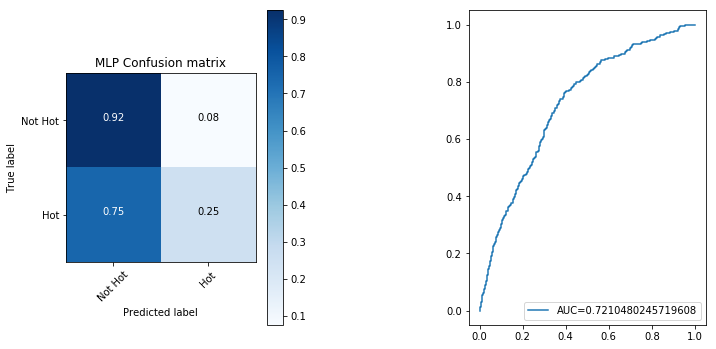

Best parameters for classifier are:
{'C': 20, 'gamma': 0.001}


In [161]:
gsmlp_preds = test_classifier(gs_mlp, X_test, y_test, name = 'MLP', grid_search=True, save = False)

## SVM

In [153]:
from sklearn.svm import SVC

svm = SVC(probability=True, class_weight = 'balanced')

# svm_params = {'C':[3, 8, 15, 20], 'degree':[2, 3, 4, 5], 'gamma':list(np.arange(0.001, 0.006, 0.001))}
svm_params = {'C':[20, 30, 40], 'gamma':[0.001]}
gs_svm = GridSearchCV(svm, param_grid=svm_params, cv=10, scoring="f1",  verbose=10)

In [154]:
gs_svm.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] C=20, gamma=0.001 ...............................................
[CV] ..... C=20, gamma=0.001, score=0.18536585365853658, total=  32.6s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.1s remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.27184466019417475, total=  27.5s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.25000000000000006, total=  28.3s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.21524663677130046, total=  29.0s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.27705627705627706, total=  30.3s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.22009569377990432, total=  31.9s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.2min remaining:    0.0s


[CV] ...... C=20, gamma=0.001, score=0.2571428571428571, total=  35.6s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.9min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.24880382775119617, total=  24.5s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.3min remaining:    0.0s


[CV] ..... C=20, gamma=0.001, score=0.21212121212121213, total=  29.8s
[CV] C=20, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.9min remaining:    0.0s


[CV] .................... C=20, gamma=0.001, score=0.32, total=  29.5s
[CV] C=30, gamma=0.001 ...............................................
[CV] ...... C=30, gamma=0.001, score=0.1862745098039216, total=  32.3s
[CV] C=30, gamma=0.001 ...............................................
[CV] ..... C=30, gamma=0.001, score=0.24752475247524752, total=  30.9s
[CV] C=30, gamma=0.001 ...............................................
[CV] ..... C=30, gamma=0.001, score=0.25120772946859904, total=  25.1s
[CV] C=30, gamma=0.001 ...............................................
[CV] ..... C=30, gamma=0.001, score=0.21818181818181817, total=  24.0s
[CV] C=30, gamma=0.001 ...............................................
[CV] ...... C=30, gamma=0.001, score=0.2794759825327511, total=  26.5s
[CV] C=30, gamma=0.001 ...............................................
[CV] ..... C=30, gamma=0.001, score=0.22857142857142856, total=  27.9s
[CV] C=30, gamma=0.001 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [20, 30, 40], 'gamma': [0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

GENERAL METRICS:
Accuracy:  0.7836
Precision:  0.3201320132013201
Recall:  0.22453703703703703
F1 score:  0.2639455782312925

             precision    recall  f1-score   support

        0.0       0.85      0.90      0.87      2068
        1.0       0.32      0.22      0.26       432

avg / total       0.76      0.78      0.77      2500


Original Confusion Matrix
[[1862  206]
 [ 335   97]]

Normalized confusion matrix
[[0.90038685 0.09961315]
 [0.77546296 0.22453704]]

ROC curve + Confusion matrix


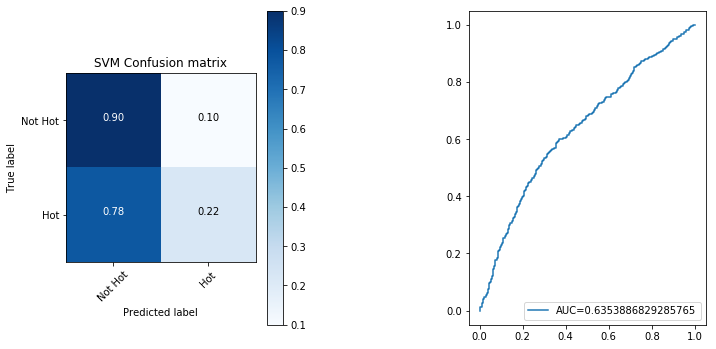

Best parameters for classifier are:
{'C': 20, 'gamma': 0.001}


In [158]:
gssvm_preds = test_classifier(gs_svm, X_test, y_test, name = 'SVM', grid_search=True, save = False)